### LDA

In [48]:
import numpy as np

class LDA():
    def __init__(self):
        # 初始化权重矩阵
        self.w = None
        
    # 计算协方差矩阵
    def calc_cov(self, X, Y=None):
        m = X.shape[0]
        # 数据标准化
        X = (X - np.mean(X, axis=0))/np.std(X, axis=0)
        Y = X if Y == None else (Y - np.mean(Y, axis=0))/np.std(Y, axis=0)
        return 1 / m * np.matmul(X.T, Y)
    
    # 对数据进行投影
    def project(self, X, y):
        self.fit(X, y)
        X_projection = X.dot(self.w)
        return X_projection
    
    # LDA拟合过程
    def fit(self, X, y):
        # 按类分组
        X0 = X[y == 0]
        X1 = X[y == 1]

        # 分别计算两类数据自变量的协方差矩阵
        sigma0 = self.calc_cov(X0)
        sigma1 = self.calc_cov(X1)
        # 计算类内散度矩阵
        Sw = sigma0 + sigma1

        # 分别计算两类数据自变量的均值和差
        u0, u1 = np.mean(X0, axis=0), np.mean(X1, axis=0)
        mean_diff = np.atleast_1d(u0 - u1)

        # 对类内散度矩阵进行奇异值分解
        U, S, V = np.linalg.svd(Sw)
        # 计算类内散度矩阵的逆
        Sw_ = np.dot(np.dot(V.T, np.linalg.pinv(np.diag(S))), U.T)
        # 计算w
        self.w = Sw_.dot(mean_diff)

    
    # LDA分类预测
    def predict(self, X):
        y_pred = []
        for sample in X:
            h = sample.dot(self.w)
            y = 1 * (h < 0)
            y_pred.append(y)
        return y_pred

In [30]:
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

data = datasets.load_iris()
X = data.data
y = data.target

In [53]:
X = X[y != 2]
y = y[y != 2]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(80, 4) (20, 4) (80,) (20,)


In [54]:
lda = LDA()
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

[-0.38776207  1.27520386 -1.697222   -0.09784557]
0.85


In [55]:
y_test

array([0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0])

In [56]:
y_pred

[0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]

In [61]:
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors

class Plot():
    def __init__(self): 
        self.cmap = plt.get_cmap('viridis')

    def _transform(self, X, dim):
        covariance = calculate_covariance_matrix(X)
        eigenvalues, eigenvectors = np.linalg.eig(covariance)
        # Sort eigenvalues and eigenvector by largest eigenvalues
        idx = eigenvalues.argsort()[::-1]
        eigenvalues = eigenvalues[idx][:dim]
        eigenvectors = np.atleast_1d(eigenvectors[:, idx])[:, :dim]
        # Project the data onto principal components
        X_transformed = X.dot(eigenvectors)

        return X_transformed


    def plot_regression(self, lines, title, axis_labels=None, mse=None, scatter=None, legend={"type": "lines", "loc": "lower right"}):
        
        if scatter:
            scatter_plots = scatter_labels = []
            for s in scatter:
                scatter_plots += [plt.scatter(s["x"], s["y"], color=s["color"], s=s["size"])]
                scatter_labels += [s["label"]]
            scatter_plots = tuple(scatter_plots)
            scatter_labels = tuple(scatter_labels)

        for l in lines:
            li = plt.plot(l["x"], l["y"], color=s["color"], linewidth=l["width"], label=l["label"])

        if mse:
            plt.suptitle(title)
            plt.title("MSE: %.2f" % mse, fontsize=10)
        else:
            plt.title(title)

        if axis_labels:
            plt.xlabel(axis_labels["x"])
            plt.ylabel(axis_labels["y"])

        if legend["type"] == "lines":
            plt.legend(loc="lower_left")
        elif legend["type"] == "scatter" and scatter:
            plt.legend(scatter_plots, scatter_labels, loc=legend["loc"])

        plt.show()



    # Plot the dataset X and the corresponding labels y in 2D using PCA.
    def plot_in_2d(self, X, y=None, title=None, accuracy=None, legend_labels=None):
        X_transformed = self._transform(X, dim=2)
        x1 = X_transformed[:, 0]
        x2 = X_transformed[:, 1]
        class_distr = []

        y = np.array(y).astype(int)

        colors = [self.cmap(i) for i in np.linspace(0, 1, len(np.unique(y)))]

        # Plot the different class distributions
        for i, l in enumerate(np.unique(y)):
            _x1 = x1[y == l]
            _x2 = x2[y == l]
            _y = y[y == l]
            class_distr.append(plt.scatter(_x1, _x2, color=colors[i]))

        # Plot legend
        if not legend_labels is None: 
            plt.legend(class_distr, legend_labels, loc=1)

        # Plot title
        if title:
            if accuracy:
                perc = 100 * accuracy
                plt.suptitle(title)
                plt.title("Accuracy: %.1f%%" % perc, fontsize=10)
            else:
                plt.title(title)

        # Axis labels
        plt.xlabel('class 1')
        plt.ylabel('class 2')

        plt.show()

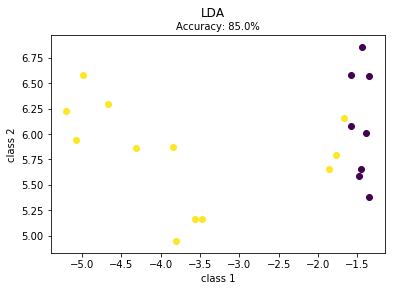

In [62]:
Plot().plot_in_2d(X_test, y_pred, title="LDA", accuracy=accuracy)

In [63]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
clf = LinearDiscriminantAnalysis()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

1.0
